In [1]:
def evaluate_models(data, dataset_name):
    import pandas as pd
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
    from xgboost import XGBClassifier
    from lightgbm import LGBMClassifier
    from sklearn.linear_model import LogisticRegression
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.naive_bayes import GaussianNB
    from sklearn.svm import SVC
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

    # --- Preprocessing ---
    type_new = pd.get_dummies(data['type'], drop_first=True)
    data_new = pd.concat([data, type_new], axis=1)
    X = data_new.drop(['isFraud', 'type', 'nameOrig', 'nameDest'], axis=1)
    y = data_new['isFraud']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
        'KNN': KNeighborsClassifier(),
        'Naive Bayes': GaussianNB(),
        'SVM': SVC(probability=True, kernel='rbf', random_state=42),
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'Random Forest': RandomForestClassifier(n_estimators=7, criterion='entropy', random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42),
        'AdaBoost': AdaBoostClassifier(random_state=42),
        'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42),
        'LightGBM': LGBMClassifier(random_state=42),
    }

    results = []
    trained_models = {}

    for name, model in models.items():
        # scale for certain models
        if name in ['SVM', 'KNN', 'Logistic Regression']:
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
            y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            y_pred_proba = model.predict_proba(X_test)[:, 1]

        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc = roc_auc_score(y_test, y_pred_proba)

        print(f'\nModel: {name} ({dataset_name})')
        print(f'Accuracy: {acc:.4f}')
        print(f'F1-Score: {f1:.4f}')
        print(f'ROC-AUC: {roc:.4f}')

        results.append({
            'Dataset': dataset_name,
            'Model': name,
            'Accuracy': acc,
            'F1-Score': f1,
            'ROC-AUC': roc
        })
        trained_models[name] = model

    return pd.DataFrame(results), trained_models, X.columns

In [2]:
import pandas as pd

orig = pd.read_csv("../data/upi_fraud_detection_dataset_under_sampled.csv")
synth = pd.read_csv("../data/synthetic_upi_fraud_detection_dataset_statistical.csv")

results_orig, models_orig, features = evaluate_models(orig, 'Original')
results_synth, models_synth, _ = evaluate_models(synth, 'Synthetic')
combined = pd.concat([results_orig, results_synth])


Model: Logistic Regression (Original)
Accuracy: 0.9320
F1-Score: 0.8573
ROC-AUC: 0.9795

Model: KNN (Original)
Accuracy: 0.9480
F1-Score: 0.8967
ROC-AUC: 0.9555

Model: Naive Bayes (Original)
Accuracy: 0.8293
F1-Score: 0.5661
ROC-AUC: 0.8379

Model: SVM (Original)
Accuracy: 0.9310
F1-Score: 0.8575
ROC-AUC: 0.9745

Model: Decision Tree (Original)
Accuracy: 0.9890
F1-Score: 0.9790
ROC-AUC: 0.9832

Model: Random Forest (Original)
Accuracy: 0.9843
F1-Score: 0.9701
ROC-AUC: 0.9950

Model: Gradient Boosting (Original)
Accuracy: 0.9903
F1-Score: 0.9817
ROC-AUC: 0.9966

Model: AdaBoost (Original)
Accuracy: 0.9647
F1-Score: 0.9321
ROC-AUC: 0.9938

Model: XGBoost (Original)
Accuracy: 0.9933
F1-Score: 0.9874
ROC-AUC: 0.9988
[LightGBM] [Info] Number of positive: 1706, number of negative: 5294
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000447 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `for

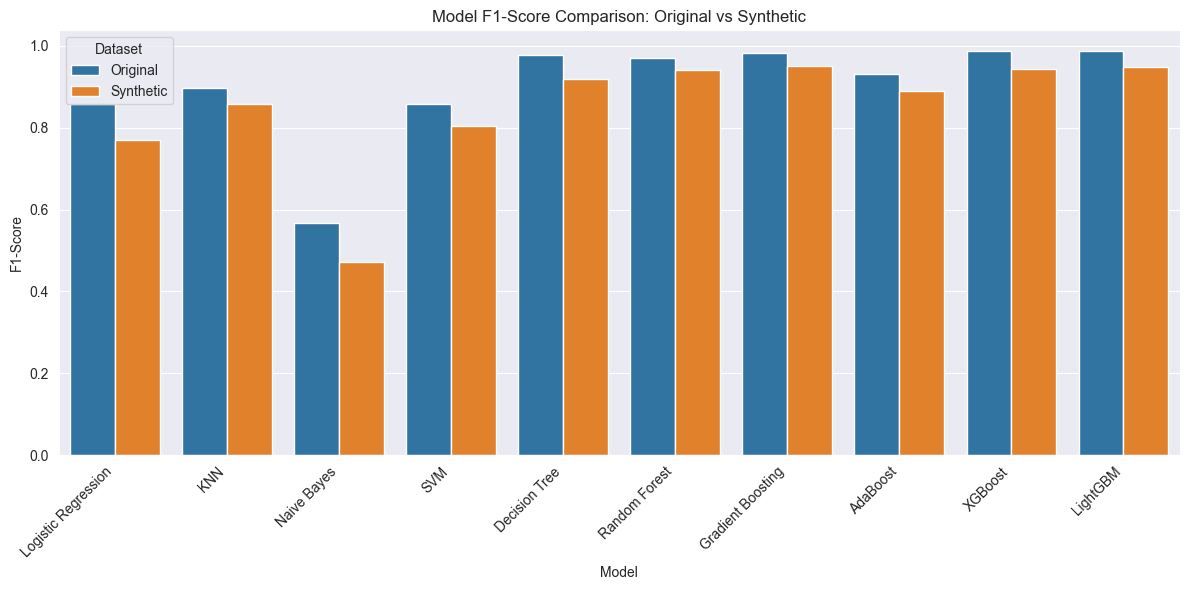

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sns.barplot(x='Model', y='F1-Score', hue='Dataset', data=combined)
plt.xticks(rotation=45, ha='right')
plt.title('Model F1-Score Comparison: Original vs Synthetic')
plt.tight_layout()
plt.show()

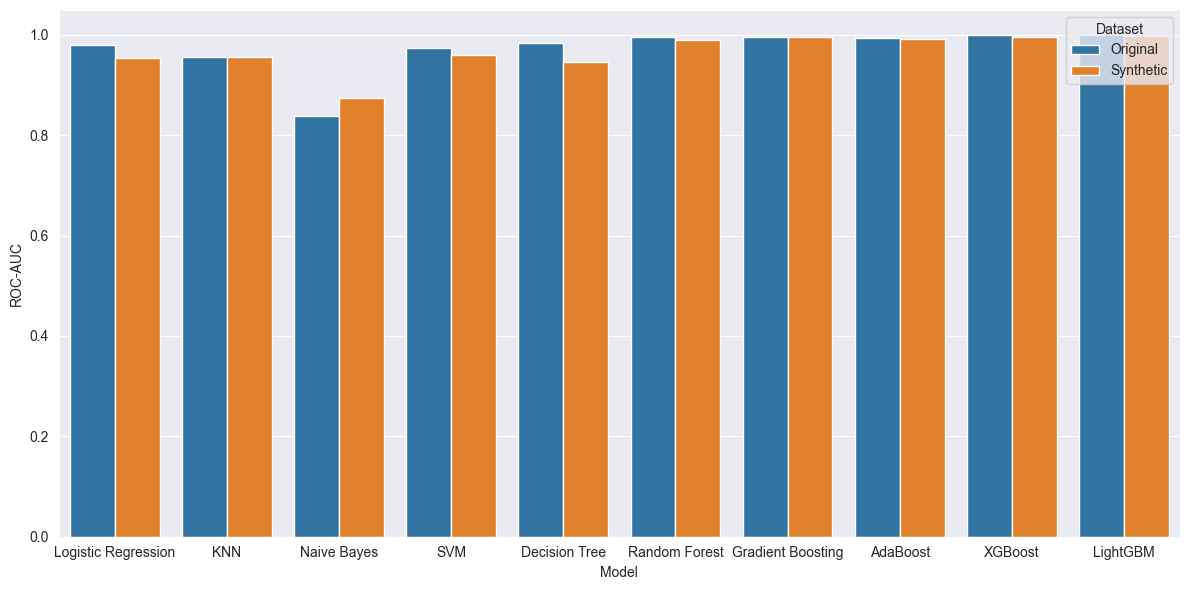

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
sns.barplot(x='Model', y='ROC-AUC', hue='Dataset', data=combined)
plt.tight_layout()
plt.show()

In [5]:
def get_feature_importance(models, dataset_name):
    import pandas as pd
    rows = []
    for name, model in models.items():
        if hasattr(model, 'feature_importances_'):
            # get correct feature names from the fitted model
            n_features = len(model.feature_importances_)
            if hasattr(model, 'feature_names_in_'):
                feat_names = model.feature_names_in_
            else:
                feat_names = [f'Feature_{i}' for i in range(n_features)]

            imp = pd.Series(model.feature_importances_, index=feat_names)
            imp = imp.sort_values(ascending=False).head(10)
            for f, val in imp.items():
                rows.append({'Dataset': dataset_name, 'Model': name, 'Feature': f, 'Importance': val})
    return pd.DataFrame(rows)

In [6]:
imp_orig = get_feature_importance(models_orig, 'Original')
imp_synth = get_feature_importance(models_synth, 'Synthetic')
imp_all = pd.concat([imp_orig, imp_synth])


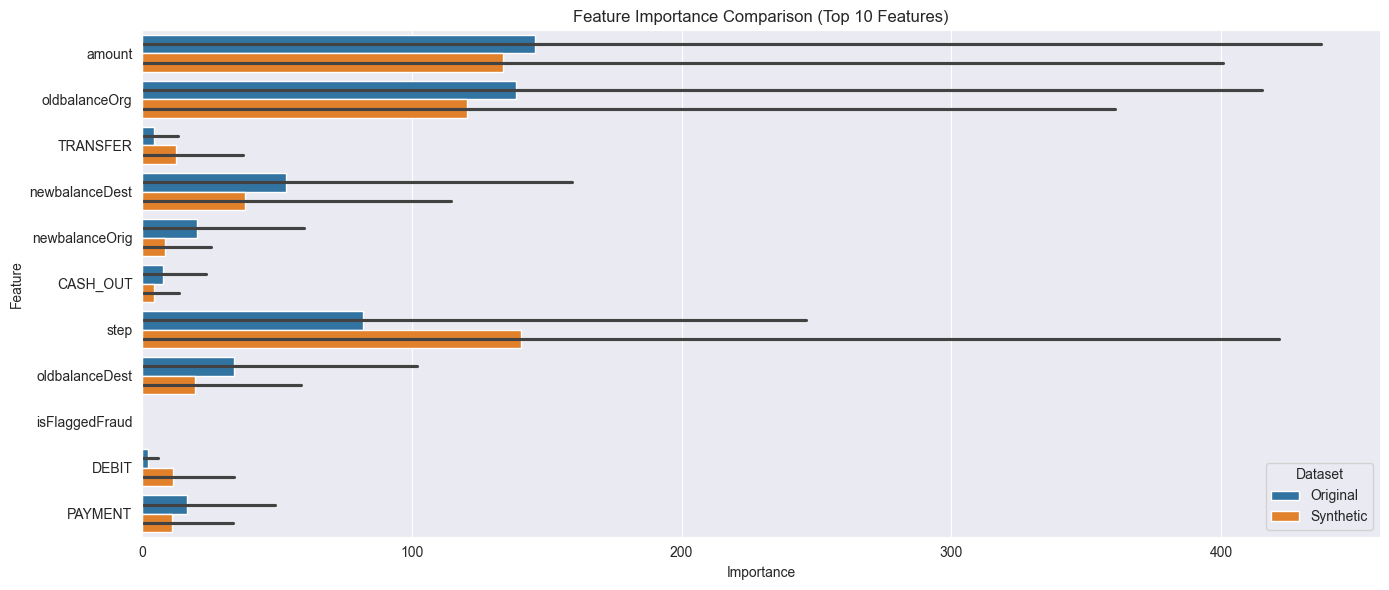

In [7]:
plt.figure(figsize=(14,6))
sns.barplot(x='Importance', y='Feature', hue='Dataset', data=imp_all)
plt.title('Feature Importance Comparison (Top 10 Features)')
plt.tight_layout()
plt.show()
